## Table of Contents
1. [Installing Libraries](#Instaling-Required-Libraries)
2. [Importing Libraries](#importing-libraries)

### 1st Approach of Annotation ❌ 
Initially, we tried using GroundedSam for automatic dataset annotation. Unfortunately, this method proved to be incorrect as GroundedSam annotated the dataset inaccurately.

3. [Train and Test Split](#train-and-test-split)
4. [Giving ontology to each and every category based on dataset](#giving-ontology-to-each-and-every-category-based-on-dataset)
5. [Auto Annotating Dataset](#auto-annotating-dataset)
6. [Updating labels file with correponding category](#updating-labels-file-with-correponding-category)

### 2nd Approach of Annotation ✅
For our preferred approach, we utilized an already annotated dataset from an open-source platform, praised for its precise human expert annotations.
#### [Link of Open source Annotated Data website](https://storage.googleapis.com/openimages/web/visualizer/index.html?type=detection&set=train&c=%2Fm%2F01mzpv)




7. [Dealing with OPEN SOURCE Annotated DATA](#dealing-with-open-source-data).
8. [Normalizing Labels](#normalizing-labels)
9. [Making Training data csv file](#making-training-data-csv-file)
10. [Making Validation data csv file](#making-csv-file-for-validation)
11. [Moving Updated labels folder to main path](#moving-updated-labels-folder-to-main-path)
12. [Training Yolov8](#training-yolov8)
12. [Testing customly trained Yolov8 Model](#testing-customly-trained-yolov8-model)
13. [Calculating time](#calculating-time)

### Instaling Required Libraries

In [1]:
# !pip install autodistill==0.1.18 autodistill-yolov8 autodistill-grounding-dino==0.1.2 supervision==0.9.0
#!pip install supervision==0.4.0 groundingdino==0.1.0 autodistill autodistill-yolov8

In [8]:
# !pip install autodistill_grounded_sam==0.1.1


In [ ]:
# #!pip install -q \
# autodistill \
# autodistill-grounded-sam \
# autodistill-yolov8 \
# supervision==0.9.0

In [ ]:
# pip install roboflow

In [1]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [1]:
!nvidia-smi

Wed Mar 27 14:08:09 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA L4           On   | 00000000:00:03.0 Off |                    0 |
| N/A   58C    P0    28W /  72W |      0MiB / 23034MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Importing Libraries

In [16]:
import sys
import os
import random
import shutil
from typing import List
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import math
import requests
import torch
import pandas as pd
import cv2
import warnings
import time
warnings.filterwarnings("ignore")

from autodistill_grounding_dino import GroundingDINO
from autodistill.detection import CaptionOntology
import supervision as sv

from autodistill_yolov8 import YOLOv8
from ultralytics import YOLO
from google.cloud import storage
from PIL import Image
import os
import matplotlib.patches as patches
import csv
from autodistill_grounded_sam import GroundedSAM


In [17]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("CUDA is available. Using GPU.")
else:
    device = torch.device("cpu")
    print("CUDA is not available. Using CPU.")


CUDA is available. Using GPU.


In [3]:
HOME = os.getcwd()
print(HOME)

/home/jupyter/yolo


## Train and Test Split

### We split Dataset categroy wise and we split data 80% to training set and 20% to testing set

In [18]:
def split_dataset_for_each_class(source_folder, train_folder, test_folder, split_ratio=0.8, seed=42):
    random.seed(seed)

    os.makedirs(train_folder, exist_ok=True)
    os.makedirs(test_folder, exist_ok=True)

    for class_folder in os.listdir(source_folder):
        class_path = os.path.join(source_folder, class_folder)

        if not os.path.isdir(class_path):
            continue

        train_class_path = os.path.join(train_folder, class_folder)
        test_class_path = os.path.join(test_folder, class_folder)

        if os.path.exists(train_class_path) or os.path.exists(test_class_path):
            print(f"Skipping {class_folder} as it already exists in train or test folder.")
            continue

        os.makedirs(train_class_path, exist_ok=True)
        os.makedirs(test_class_path, exist_ok=True)

        images = [img for img in os.listdir(class_path) if img.endswith(('.jpg', '.jpeg', '.png'))]
        num_images = len(images)

        random.shuffle(images)

        num_train = int(split_ratio * num_images)

        # Move images to the training set
        for img in images[:num_train]:
            src_path = os.path.join(class_path, img)
            dst_path = os.path.join(train_class_path, img)
            shutil.copy(src_path, dst_path)

        for img in images[num_train:]:
            src_path = os.path.join(class_path, img)
            dst_path = os.path.join(test_class_path, img)
            shutil.copy(src_path, dst_path)

source_folder = "/home/jupyter/gcs/yolodataset"  
train_folder = "/home/jupyter/gcs/train"      
test_folder = "/home/jupyter/gcs/test"        

split_dataset_for_each_class(source_folder, train_folder, test_folder, split_ratio=0.8, seed=42)

Skipping bed as it already exists in train or test folder.
Skipping bench as it already exists in train or test folder.
Skipping cabinet as it already exists in train or test folder.
Skipping chair as it already exists in train or test folder.
Skipping mattress as it already exists in train or test folder.
Skipping mirror as it already exists in train or test folder.
Skipping pillow as it already exists in train or test folder.
Skipping shelves as it already exists in train or test folder.
Skipping sofa as it already exists in train or test folder.
Skipping table as it already exists in train or test folder.


In [4]:
IMAGE_DIR_PATH="/home/jupyter/data/train/mattress"

In [7]:

image_paths = sv.list_files_with_extensions(
    directory=IMAGE_DIR_PATH,
    extensions=["png"])

print('image count:', len(image_paths))

image count: 142


## Giving ontology to each and every category based on dataset

#### We individually annotated each category by assigning specific ontologies accordingly.

In [11]:

ontology=CaptionOntology({
    "full_sofa": "sofa",
    "lshape_sofa":"sofa",
})

In [12]:
DATASET_DIR_PATH="/home/jupyter/gcs/yolo/output/mattress"

## Auto Annotating Dataset
### Following that, we utilized GroundedSam for automatic dataset annotation.

In [ ]:
base_model = GroundingDINO(ontology=ontology)
# extensions = ".jpg, .png, .jpeg"

# dataset = base_model.label(
#     input_folder=IMAGE_DIR_PATH,
#     extension=".jpeg",
#     output_folder=DATASET_DIR_PATH)

dataset = base_model.label(
    input_folder=IMAGE_DIR_PATH,
    extension=".jpg",
    output_folder=DATASET_DIR_PATH)
# dataset = base_model.label(
#     input_folder=IMAGE_DIR_PATH,
#     extension=".png",
#     output_folder=DATASET_DIR_PATH)


trying to load grounding dino directly


torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)


final text_encoder_type: bert-base-uncased


Labeling /home/jupyter/gcs/train/sofa/01871aca-ef45-4e7a-aba8-8a74bf115f25_image_8.jpg:   0%|          | 0/949 [00:00<?, ?it/s]The `device` argument is deprecated and will be removed in v5 of Transformers.
torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
None of the inputs have requires_grad=True. Gradients will be None
2023-12-11 07:03:54.979853: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-11 07:03:58.810425: E external/local_xla/xla/stream_executor/cuda/cuda_

In [3]:
ANNOTATIONS_DIRECTORY_PATH = "/home/jupyter/gcs/yolo/output/sofa/train/labels"
IMAGES_DIRECTORY_PATH = "/home/jupyter/gcs/yolo/output/sofa/train/images"
DATA_YAML_PATH = "/home/jupyter/gcs/yolo/output/sofa/data.yaml"

In [ ]:

dataset = sv.DetectionDataset.from_yolo(
    images_directory_path=IMAGES_DIRECTORY_PATH,
    annotations_directory_path=ANNOTATIONS_DIRECTORY_PATH,
    data_yaml_path=DATA_YAML_PATH)

len(dataset)

## Updating labels file with correponding category
####  After completing the annotation process, we updated the label files using the specific indices assigned to each category.

In [28]:
categories = {
    # 'bed':0,
    # 'bench': 1,
    # 'cabinet':2,
    # 'chair':3,
    # 'mattress':4,
    # 'lamp':5,
    # 'rugs':6,
    # 'pillow':8,
    # 'shelves':9,
    # 'sofa':10,
    'table':11
}
# train and valid
folder_path="/home/jupyter/gcs/yolo/output/table/valid/labels/"
for category, label in categories.items():
    # Check if the root folder exists
    if os.path.exists(folder_path):


        # Iterate through each label file in the root folder
        for filename in os.listdir(folder_path):
            if filename.endswith('.txt'):
                input_file_path = os.path.join(folder_path, filename)

                # Read the contents of the label file
                with open(input_file_path, 'r') as file:
                    lines = file.readlines()

                # Replace the class values '0' and '1' with the corresponding category label
                updated_lines = []
                for line in lines:
                    parts = line.strip().split(' ')
                    if len(parts) > 0:
                        
                        # Replace class values '0' ,'1' and '2' with the corresponding category label
                        if parts[0] == '0' or parts[0] == '1' or parts[0] == '2':
                            parts[0] = str(label)
                

                        # Replace other occurrences of '0' with the corresponding category label
                        for i in range(1, len(parts)):
                            if parts[i] == '0':
                                parts[i] = str(label)

                        updated_lines.append(' '.join(parts) + '\n')
#                        
                with open(input_file_path, 'w') as file:
                    file.writelines(updated_lines)


        print(f"Label files for category '{category}' updated.")
    else:
        print(f"Folder '{folder_path}' not found.")

print("All label files updated.")
 

Label files for category 'table' updated.
All label files updated.


## Dealing with OPEN SOURCE DATA

### Normalizing Labels
#### We normalized the labels to fit the YOLOv8 requirements, which involve scaling labels to a range of 0-1.

In [ ]:

# Function to normalize coordinates
def normalize_coordinates(coords, img_width, img_height):
    x_min, y_min, x_max, y_max = coords
    
    center_x = (x_max + x_min) / 2
    center_y = (y_max + y_min) / 2
   
    w = x_max - x_min
    h = y_max - y_min
 
    x_norm = center_x / img_width
    y_norm = center_y / img_height
    w_norm = w / img_width
    h_norm = h / img_height
    
    return x_norm, y_norm, w_norm, h_norm

# Directory containing images and label files
parent_directory = "/home/jupyter/data/Annotated_data/valid/Table/"

# Subdirectories for images and labels
image_directory = os.path.join(parent_directory, "images")
label_directory = os.path.join(parent_directory, "labels")
image_count=0
start_time = time.time()

for filename in os.listdir(image_directory):
    if filename.endswith(".jpg"):
        image_path = os.path.join(image_directory, filename)
        label_path = os.path.join(label_directory, filename[:-4] + ".txt")  
        # print(label_path)
        with Image.open(image_path) as img:
            img_width, img_height = img.size

        try:
            with open(label_path, 'r') as label_file:
                lines = label_file.readlines()
        except FileNotFoundError:
            print(f"Label file '{label_path}' not found for image '{image_path}'. Skipping...")
            continue

        if len(lines) == 0:
            print(f"Label file '{label_path}' is empty for image '{image_path}'. Skipping...")
            continue

        with open(label_path, 'w') as label_file:
            for line in lines:
                line = line.strip().split()
                if len(line) == 4:  # Handling the case when y_max is missing
                    print(f"Skipping label entry with missing y_max: {line}")
                    continue  # Skip processing this line
                elif len(line) == 5:
                    class_id = line[0]
                    x_min = float(line[1])
                    y_min = float(line[2])
                    x_max = float(line[3])
                    y_max = float(line[4])            
                    x_norm, y_norm, w_norm, h_norm = normalize_coordinates((x_min, y_min, x_max, y_max), img_width, img_height)
                    label_file.write(f"{int(class_id)} {x_norm} {y_norm} {w_norm} {h_norm}\n")
                else:
                    print(f"Invalid format in label file '{label_path}'. Skipping...")
                    continue
        image_count+=1
        # print(f"Processed image '{image_path}' and saved the normalized labels.")
    else:
        print(f"Skipping non-image file '{filename}'.")
elapsed_time = time.time() - start_time
elapsed_minutes = elapsed_time / 60

print(f"Processed {image_count} images in {elapsed_time} seconds ({elapsed_minutes} minutes).")
print("Processing complete.")


### Testing that new generated labels are correct or not

In [ ]:


def visualize_bbox(image_path, bbox):
    # Read image
    image = plt.imread(image_path)
    img_height, img_width, _ = image.shape

    # Denormalize bounding box
    x, y, w, h = bbox
    x = x * img_width
    y = y * img_height
    w = w * img_width
    h = h * img_height

    # Create figure and axis
    fig, ax = plt.subplots()

    # Display the image
    ax.imshow(image)

    # Draw bounding box
    rect = patches.Rectangle((x - w / 2, y - h / 2), w, h, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

    # Show the plot
    plt.show()

# Path to the image
image_path = "/home/jupyter/data/yolo/output/train/images/9aab7c63eaf9b2ef.jpg"

# Bounding box values
bbox_values = (0.4796875 ,0.5171875 ,0.9343750000000001 ,0.518751)

# Visualize bounding box
visualize_bbox(image_path, bbox_values)


### Moving Updated labels folder to main path 

In [70]:

source_directories = [
    "/home/jupyter/data/Annotated_data/train/Bed/Labels",
    "/home/jupyter/data/Annotated_data/train/Cabinet/Labels",
    "/home/jupyter/data/Annotated_data/train/Lamp/Labels",
    "/home/jupyter/data/Annotated_data/train/Mirror/Labels",
    "/home/jupyter/data/Annotated_data/train/Pillow/Labels",
    "/home/jupyter/data/Annotated_data/train/Shelf/labels",
    "/home/jupyter/data/Annotated_data/train/Sofa/labels",
    "/home/jupyter/data/Annotated_data/train/chair/Labels",
    "/home/jupyter/data/Annotated_data/train/rugs/train/labels",
    "/home/jupyter/data/Annotated_data/train/table/labels"
]

target_directory = "/home/jupyter/data/yolo/output/train/labels"

# Iterate over source directories
total_files_copied = 0
total_errors = 0

# Iterate over source directories
for source_directory in source_directories:
    # Iterate over files in source directory
    for file_name in os.listdir(source_directory):
        # Check if the file is an image file
        if file_name.endswith((".txt")):
            try:
                # Construct source and target file paths
                source_file_path = os.path.join(source_directory, file_name)
                target_file_path = os.path.join(target_directory, file_name)
                # Copy the file to the target directory
                shutil.copyfile(source_file_path, target_file_path)
                total_files_copied += 1
                # print(f"File '{file_name}' copied successfully.")

            except Exception as e:
                print(f"Error copying file {file_name}: {e}")
                total_errors += 1
print("Labels copied successfully.")
print(f"Total files copied: {total_files_copied}")
print(f"Total errors encountered: {total_errors}")



Labels copied successfully.
Total files copied: 18571
Total errors encountered: 0


In [71]:
source_directories = [
    "/home/jupyter/data/Annotated_data/valid/Bed/labels",
    "/home/jupyter/data/Annotated_data/valid/Cabinet/labels",
    "/home/jupyter/data/Annotated_data/valid/Lamp/labels",
    "/home/jupyter/data/Annotated_data/valid/Mirror/labels",
    "/home/jupyter/data/Annotated_data/valid/Pillow/labels",
    "/home/jupyter/data/Annotated_data/valid/Shelf/labels",
    "/home/jupyter/data/Annotated_data/valid/Sofa/labels",
    "/home/jupyter/data/Annotated_data/valid/Chair/labels",
    "/home/jupyter/data/Annotated_data/valid/rugs/valid/labels",
    "/home/jupyter/data/Annotated_data/valid/Table/labels"
]


target_directory = "/home/jupyter/data/yolo/output/valid/labels"


total_files_copied = 0
total_errors = 0

# Iterate over source directories
for source_directory in source_directories:
    # Iterate over files in source directory
    for file_name in os.listdir(source_directory):
        # Check if the file is an image file
        if file_name.endswith(".txt"):
            try:
                # Construct source and target file paths
                source_file_path = os.path.join(source_directory, file_name)
                target_file_path = os.path.join(target_directory, file_name)
                # Copy the file to the target directory
                shutil.copyfile(source_file_path, target_file_path)
                total_files_copied += 1
            except Exception as e:
                print(f"Error copying file {file_name}: {e}")
                total_errors += 1
print("Labels copied successfully.")
print(f"Total files copied: {total_files_copied}")
print(f"Total errors encountered: {total_errors}")


Labels copied successfully.
Total files copied: 1203
Total errors encountered: 0


### Making Training data csv file
#### CSV files for both training and validation data were created to maintain organization and to monitor dataset characteristics effectively.

In [109]:
client = storage.Client()
label_mapping={
    0:'Bed',
    # 'bench': 1,
    2:'Cabinet',
    3:'Chair',
    # 'mattress':4,
    5:'Lamp',
    6:'Rug',
    7:'Mirror',
    8:'Pillow',
    9:'Shelf',
    10:'Sofa',
    11:'Table'

}

def convert_label(label):
    return label_mapping.get(int(label), 'Unknown')



bucket_name = "image_search_data"

parent_directory = "/home/jupyter/data/Annotated_data/train"

categories_to_process = ["Shelf", "Sofa", "table"]
# bed,cabinet,lamp done
# mirror,pillow,chair done

csv_file_path = "/home/jupyter/yolo/Training_data.csv"

# Open CSV file in write mode
with open(csv_file_path, "a", newline="") as csvfile:
    writer = csv.writer(csvfile)
    # Write header row
    writer.writerow(["ML_USE", "GCS_FILE_PATH", "LABEL", "BOUNDING_BOX"])

    # Iterate over categories to process
    for category in categories_to_process:
        category_directory = os.path.join(parent_directory, category)
        if os.path.isdir(category_directory):
            images_directory = os.path.join(category_directory, "images")
            labels_directory = os.path.join(category_directory, "labels")

            # Iterate over image files in the current category
            for image_filename in os.listdir(images_directory):
                if image_filename.endswith(".jpg"):
                    label_filename = os.path.basename(image_filename).replace(".jpg", ".txt")
                    gcs_images_directory = images_directory.split('Annotated_data')[1]
                    gcs_file_path = f"gs://{bucket_name}/Annotated_data{gcs_images_directory}/{image_filename}"

                    if os.path.exists(os.path.join(labels_directory, label_filename)):

                        with open(os.path.join(labels_directory, label_filename), "r") as label_file:
                            for line in label_file:
                                label_info = line.strip().split()
                                if label_info:
                                    letter_label = convert_label(label_info[0])
                                else:
                                    print(f"Empty line encountered in file {label_filename}")
                                    continue
                                # letter_label = convert_label(label_info[0])
                                if len(label_info[1:]) == 3:
                                    x_min, x_max, y_min = label_info[1:]
                                    y_max = ''  # Provide a default value or handle the absence of ymax
                                elif len(label_info[1:]) == 4:
                                    x_min, x_max, y_min, y_max = label_info[1:]
                                else:
                                    print(f"Invalid label format in file {label_filename}: {line.strip()}")
                                    continue
                                writer.writerow(["TRAINING", gcs_file_path, letter_label, f"{x_min},{y_min},{x_max},{y_max}"])

                                

print("CSV file for specified categories has been created successfully.")


/home/jupyter/data/Annotated_data/train/rugs/train
/home/jupyter/data/Annotated_data/train/rugs/train/images
CSV file for specified categories has been created successfully.


In [148]:
client = storage.Client()
label_mapping={
    0:'Bed',
    # 'bench': 1,
    2:'Cabinet',
    3:'Chair',
    # 'mattress':4,
    5:'Lamp',
    6:'Rug',
    7:'Mirror',
    8:'Pillow',
    9:'Shelf',
    10:'Sofa',
    11:'Table'

}

def convert_label(label):
    return label_mapping.get(int(label), 'Unknown')


bucket_name = "image_search_data"
parent_directory = "/home/jupyter/data/Annotated_data/train/rugs/train"
categories_to_process = ["rugs"]
csv_file_path = "/home/jupyter/yolo/Training_data.csv"

# Check if CSV file exists and is empty
is_empty = not os.path.exists(csv_file_path) or os.stat(csv_file_path).st_size == 0

# Open CSV file in append mode
with open(csv_file_path, "a", newline="") as csvfile:
    writer = csv.writer(csvfile)

    # Write header row if the file is empty
    # writer.writerow(["ML_USE", "GCS_FILE_PATH", "LABEL", "BOUNDING_BOX"])

    # Iterate over categories to process
    for category in categories_to_process:
        category_directory = (parent_directory)
        if os.path.isdir(parent_directory):
            images_directory = os.path.join(category_directory, "images")
            labels_directory = os.path.join(category_directory, "labels")

            # Iterate over image files in the current category
            for image_filename in os.listdir(images_directory):
                if image_filename.endswith(".jpg"):
                    label_filename = os.path.basename(image_filename).replace(".jpg", ".txt")
                    gcs_images_directory = images_directory.split('Annotated_data')[1]
                    gcs_file_path = f"gs://{bucket_name}/Annotated_data{gcs_images_directory}/{image_filename}"

                    if os.path.exists(os.path.join(labels_directory, label_filename)):
                        with open(os.path.join(labels_directory, label_filename), "r") as label_file:
                            for line in label_file:
                                label_info = line.strip().split()
                                letter_label = convert_label(label_info[0])
                                bounding_box = ','.join(label_info[1:])
                                writer.writerow(["TRAINING", gcs_file_path, letter_label, bounding_box])

print("CSV file for specified categories has been created successfully.")

CSV file for specified categories has been created successfully.


In [149]:
df=pd.read_csv("/home/jupyter/yolo/Training_data.csv")
df

,ML_USE,GCS_FILE_PATH,LABEL,BOUNDING_BOX
0,TRAINING,gs://image_search_data/Annotated_data/train/Be...,Bed,"138.354688,375.407616,284.727921,423.125"
1,TRAINING,gs://image_search_data/Annotated_data/train/Be...,Bed,"184.178688,415.064064,295.306046,580.033967"
2,TRAINING,gs://image_search_data/Annotated_data/train/Be...,Bed,"0.0,771.2,224.24939,678.514739"
3,TRAINING,gs://image_search_data/Annotated_data/train/Be...,Bed,"300.8,919.68,192.854612,623.413714"
4,TRAINING,gs://image_search_data/Annotated_data/train/Be...,Bed,"92.8,699.52,326.4,713.600256"
...,...,...,...,...
46507,TRAINING,gs://image_search_data/Annotated_data/train/ru...,Rug,"0.79,0.7925,0.195,0.7775000000000001,0.03,0.96..."
46508,TRAINING,gs://image_search_data/Annotated_data/train/ru...,Rug,"0.20249999999999999,0.7875,0.0325,0.975,0.9550..."
46509,TRAINING,gs://image_search_data/Annotated_data/train/ru...,Rug,"0.4525,0.4575,0.1375,0.4625,0.0875,0.9875,0.83..."
46510,TRAINING,gs://image_search_data/Annotated_data/train/ru...,Rug,"0.45999999999999996,0.45499999999999996,0.1375..."


### Making csv file for Validation

In [164]:
client = storage.Client()
label_mapping={
    0:'Bed',
    # 'bench': 1,
    2:'Cabinet',
    3:'Chair',
    # 'mattress':4,
    5:'Lamp',
    6:'Rug',
    7:'Mirror',
    8:'Pillow',
    9:'Shelf',
    10:'Sofa',
    11:'Table'

}

def convert_label(label):
    return label_mapping.get(int(label), 'Unknown')



bucket_name = "image_search_data"

parent_directory = "/home/jupyter/data/Annotated_data/valid"
categories_to_process = ["Chair"]
# bed,cabinet,lamp done
# mirror,pillow,chair done

csv_file_path = "/home/jupyter/yolo/Validation_data.csv"

# Open CSV file in write mode
with open(csv_file_path, "a", newline="") as csvfile:
    writer = csv.writer(csvfile)
    # Write header row
    # writer.writerow(["ML_USE", "GCS_FILE_PATH", "LABEL", "BOUNDING_BOX"])

    # Iterate over categories to process
    for category in categories_to_process:
        category_directory = os.path.join(parent_directory, category)
        if os.path.isdir(category_directory):
            images_directory = os.path.join(category_directory, "images")
            labels_directory = os.path.join(category_directory, "labels")

            # Iterate over image files in the current category
            for image_filename in os.listdir(images_directory):
                if image_filename.endswith(".jpg"):
                    label_filename = os.path.basename(image_filename).replace(".jpg", ".txt")
                    gcs_images_directory = images_directory.split('Annotated_data')[1]
                    gcs_file_path = f"gs://{bucket_name}/Annotated_data{gcs_images_directory}/{image_filename}"

                    if os.path.exists(os.path.join(labels_directory, label_filename)):

                        with open(os.path.join(labels_directory, label_filename), "r") as label_file:
                            for line in label_file:
                                label_info = line.strip().split()
                                if label_info:
                                    letter_label = convert_label(label_info[0])
                                else:
                                    print(f"Empty line encountered in file {label_filename}")
                                    continue
                                # letter_label = convert_label(label_info[0])
                                if len(label_info[1:]) == 3:
                                    x_min, x_max, y_min = label_info[1:]
                                    y_max = ''  # Provide a default value or handle the absence of ymax
                                elif len(label_info[1:]) == 4:
                                    x_min, x_max, y_min, y_max = label_info[1:]
                                else:
                                    print(f"Invalid label format in file {label_filename}: {line.strip()}")
                                    continue
                                writer.writerow(["VALIDATION", gcs_file_path, letter_label, f"{x_min},{y_min},{x_max},{y_max}"])

                                

print("CSV file for specified categories has been created successfully.")


CSV file for specified categories has been created successfully.


In [163]:
df=pd.read_csv("Validation_data.csv")
df

,ML_USE,GCS_FILE_PATH,LABEL,BOUNDING_BOX
0,VALIDATION,gs://image_search_data/Annotated_data/valid/Be...,Bed,"0.0,1022.4874496,152.72627110000002,683.4878625"
1,VALIDATION,gs://image_search_data/Annotated_data/valid/Be...,Bed,"186.368,733.184,411.648,712.7040000000001"
2,VALIDATION,gs://image_search_data/Annotated_data/valid/Be...,Bed,"385.024,1013.76,456.70399488,768.0"
3,VALIDATION,gs://image_search_data/Annotated_data/valid/Be...,Bed,"219.48541154,767.3978961600001,491.96868608,10..."
4,VALIDATION,gs://image_search_data/Annotated_data/valid/Be...,Bed,"0.0,369.6,140.80000512,595.2"
...,...,...,...,...
1445,VALIDATION,gs://image_search_data/Annotated_data/valid/ru...,Rug,"0.8574999999999999,0.9875,6,0.9,0.4175,0.53499..."
1446,VALIDATION,gs://image_search_data/Annotated_data/valid/ru...,Rug,"0.6475,0.6,0.155,0.5974999999999999,0.0475,0.9..."
1447,VALIDATION,gs://image_search_data/Annotated_data/valid/ru...,Rug,"0.635,0.6025,0.16,0.6075,0.04,0.96,0.965000000..."
1448,VALIDATION,gs://image_search_data/Annotated_data/valid/ru...,Rug,"0.6275000000000001,0.6025,0.16999999999999998,..."


#### Giving Data Yaml file path

In [11]:
DATA_YAML_PATH="/home/jupyter/gcs/yolo/data.yaml"

### Training Yolov8
#### We proceeded to train YOLOv8, specifying the necessary configurations in the data.yaml file and setting the appropriate number of training epochs.

In [ ]:
model = YOLO("yolov8n.pt")
model.to(device)
model.train(data=DATA_YAML_PATH, epochs=100)

New https://pypi.org/project/ultralytics/8.1.34 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.81 🚀 Python-3.10.13 torch-2.1.1+cu118 CUDA:0 (NVIDIA L4, 22518MiB)
yolo/engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/home/jupyter/gcs/yolo/data.yaml, epochs=100, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=False, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, image_weights=False, rect=False, cos_lr=False, close_mosaic=0, resume=False, amp=True, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, line_thickness=3, visualize=False, augment=False, agnostic_nms=False, classes=None,

## Testing customly trained Yolov8 Model 

In [8]:
def choose_and_crop(image_path, yolo_weights):
    model=YOLO(yolo_weights)
    results = model(image_path)
    for result in results:
        im_array = result.plot()  
        im_rgb = im_array[..., ::-1]  
        plt.figure(figsize=(12,8))
        plt.imshow(im_rgb)
        plt.show()
 
    for i, result in enumerate(results[0].boxes):
        class_index = result.cls
        conf = float(result.conf[0].cpu().numpy())  
        class_label = model.names[int(class_index)]
        print(f"{i + 1}: {class_label} {conf:.2f}")

    # Ask the user to choose an index
    chosen_index = input("Enter the index of the label you want to choose (or press Enter to skip): ")

    if chosen_index:
        chosen_index = int(chosen_index) - 1  # Adjust to 0-based index

        if 0 <= chosen_index < len(results[0].boxes):
            chosen_label = model.names[int(results[0].boxes[chosen_index].cls)]
            chosen_box = results[0].boxes[chosen_index].xyxy[0, :4].cpu().numpy().astype(int)

            image = Image.open(image_path)
            cropped_region = image.crop((chosen_box[0], chosen_box[1], chosen_box[2], chosen_box[3]))

            # Display the cropped region
            plt.imshow(cropped_region)
            plt.show()
            return cropped_region
        else:
            print("Invalid index. Please enter a valid index.")
    else:
        return None



In [17]:
yolo_weights="/home/jupyter/yolo/best.pt"
image_path="/home/jupyter/data/test/bed/bed_86.png"

# yolo_weights="/home/jupyter/yolo/runs/detect/train6/weights/best.pt"

# cropped_region = choose_and_crop(image_path, yolo_weights)



image 1/1 /home/jupyter/data/test/bed/bed_86.png: 640x640 1 potted plant, 1 bed, 5.6ms
Speed: 0.5ms preprocess, 5.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


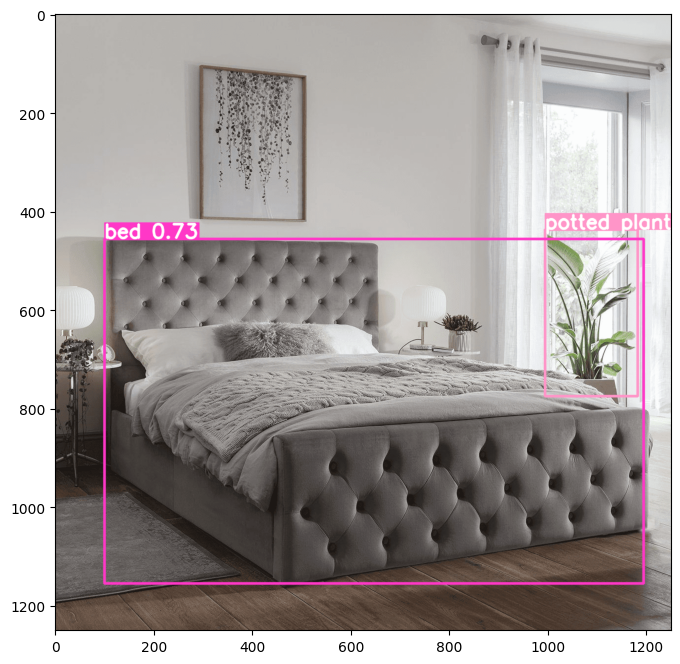

In [20]:

model=YOLO(yolo_weights)
results = model(image_path)
for result in results:
    im_array = result.plot()  
    im_rgb = im_array[..., ::-1]  
    plt.figure(figsize=(12,8))
    plt.imshow(im_rgb)
    plt.show()

## Calculating time 

In [34]:
source="/home/jupyter/gcs/test/cabinet/"
results=model(source,conf=0.75)



image 1/430 /home/jupyter/gcs/test/cabinet/04b26223-a640-4f7c-b40d-0b2df6e6c23e_image_4.jpg: 544x640 1 cabinet, 9.6ms
image 2/430 /home/jupyter/gcs/test/cabinet/06a6ca99-993d-4cbe-b4ce-3d9b8f783928_image_3.jpg: 544x640 1 cabinet, 7.8ms
image 3/430 /home/jupyter/gcs/test/cabinet/10_prod2740042_8d3ea3bc-f65b-4227-9fa6-6fae40e4575a.jpg: 640x480 1 table, 9.9ms
image 4/430 /home/jupyter/gcs/test/cabinet/1273_prod1760431_201cb789-4198-488b-a5eb-4e7df0fb4bee.jpg: 640x480 1 lamp, 7.6ms
image 5/430 /home/jupyter/gcs/test/cabinet/1302_prod3160065_201cb789-4198-488b-a5eb-4e7df0fb4bee.jpg: 640x480 1 table, 7.6ms
image 6/430 /home/jupyter/gcs/test/cabinet/1356_prod2950018_201cb789-4198-488b-a5eb-4e7df0fb4bee.jpg: 480x640 (no detections), 8.1ms
image 7/430 /home/jupyter/gcs/test/cabinet/1518_5878f188-9e98-4fe3-abbc-6fd662756eb2_201cb789-4198-488b-a5eb-4e7df0fb4bee.jpg: 640x480 1 cabinet, 7.9ms
image 8/430 /home/jupyter/gcs/test/cabinet/1563_prod2370164_201cb789-4198-488b-a5eb-4e7df0fb4bee.jpg: 480x